# Training random forest model with scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("fungi-incognita-experiment")

<Experiment: artifact_location='/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/fungiIncognita/notebooks/mlruns/1', creation_time=1733079958846, experiment_id='1', last_update_time=1733079958846, lifecycle_stage='active', name='fungi-incognita-experiment', tags={}>

In [4]:
# load the data
df = pd.read_csv("../data/secondary_data_generated_with_names.csv", sep=";")

# shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# drop columns with missing values
df_no_missing = df.dropna(axis=1, inplace=False)
df_no_missing = df_no_missing.drop(columns=["family"], inplace=False)
df_no_missing = df_no_missing.drop(columns=["class"], inplace=False)

In [5]:
df_full_train, df_test = train_test_split(
    df_no_missing, test_size=0.2, random_state=42, stratify=df_no_missing["name"]
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=42, stratify=df_full_train["name"]
)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.name.values
y_val = df_val.name.values
y_test = df_test.name.values

del df_train["name"]
del df_val["name"]
del df_test["name"]

In [6]:
cat_features = [
    #    "family",
    #    "class",
    "cap-shape",
    "cap-color",
#    "does-bruise-or-bleed",
    "gill-color",
    "stem-color",
#    "has-ring",
    "habitat",
    "season",
]

In [7]:
num_features = [
    "cap-diameter",
    "stem-height",
    "stem-width",
]

In [8]:
dv = DictVectorizer(sparse=False)

# Convert categorical features to dictionary format
train_dicts = df_train[cat_features + num_features].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[cat_features + num_features].to_dict(orient="records")
X_val = dv.transform(val_dicts)

test_dicts = df_test[cat_features + num_features].to_dict(orient="records")
X_test = dv.transform(test_dicts)


In [9]:
# dv.feature_names_

In [10]:
feature_names = [f"feature {i}" for i in enumerate(dv.feature_names_)]

In [ ]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_val)

accuracy = (y_pred == y_val).mean()

In [11]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.032 seconds


## Feature importance based on mean decrease in impurity

[Feature importances with a forest of trees - scikit learn example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

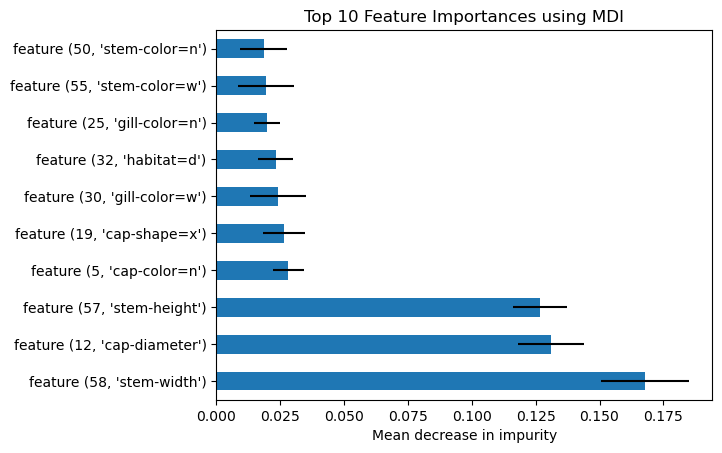

In [12]:
import matplotlib.pyplot as plt

# Sort the importances and select the top 10
forest_importances = pd.Series(importances, index=feature_names)
top_10_importances = forest_importances.sort_values(ascending=False).head(10)
top_10_indices = [feature_names.index(name) for name in top_10_importances.index]
top_10_std = std[top_10_indices]

fig, ax = plt.subplots()
top_10_importances.plot(kind="barh", x=top_10_indices, y=top_10_importances, xerr=top_10_std, ax=ax)
ax.set_title("Top 10 Feature Importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
plt.show();

## Feature importance based on feature permutation

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


/opt/homebrew/Caskroom/miniforge/base/envs/fungi_Incognita/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


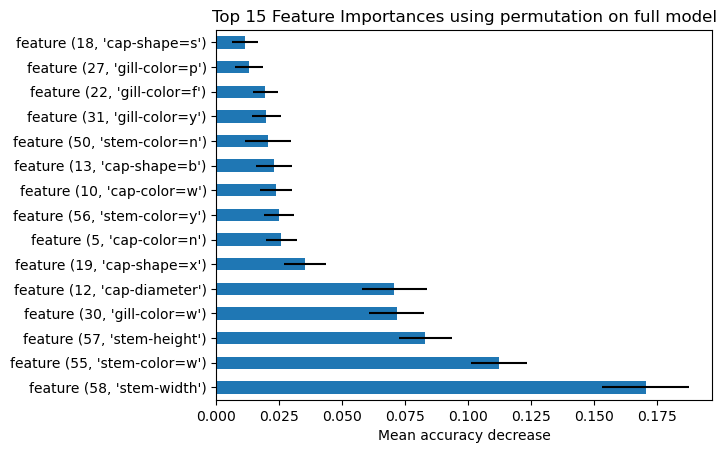

In [ ]:
# Sort the importances and select the top 15
top_15_importances = forest_importances.sort_values(ascending=False).head(15)
top_15_indices = [feature_names.index(name) for name in top_15_importances.index]
top_15_std = std[top_15_indices]

fig, ax = plt.subplots()
top_15_importances.plot(kind="barh", x=top_15_indices, y=top_15_importances, xerr=top_15_std, ax=ax)
ax.set_title(
    "Top 15 Feature Importances using permutation on full model"
)
ax.set_xlabel("Mean accuracy decrease")
plt.show()

In [12]:
accuracy

0.9811691501555592